In [11]:
from DAVE import *
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy import sinh, cosh, sqrt

In [12]:
mass_per_lengh = 1
length = 80
EA = 1e6    # <-- should be a high number as the analytical equation does not account for stretch
segments = 100
width = 60

In [13]:
# analytical



# We know the width and length of the catenary
# The standard formula for a catenary describe half of a symmetric catenary

s =  length / 2
x =  width / 2

# solve s = a sinh(x/a)

def should_be_zero(a):
    return a * sinh(x/a) - s

a_guess = 1
a = fsolve(should_be_zero, a_guess)

T0 = a * mass_per_lengh * 9.81

print(f'T0 (horizontal tension = {T0}')

T0 (horizontal tension = [217.7983993]


In [14]:
s = Scene()
p1 = s.new_poi('p1',position=(-width/2,0,0))
p2 = s.new_poi('p2',position=(width/2,0,0))

In [15]:
# construct the catenary


mass_per_body = mass_per_lengh * length / segments

for i in range(segments):
    b = s.new_rigidbody(name = f'body{i}', mass = mass_per_body,
                        fixed=(False,True,False,True,True,True))  # only free in X and Z
    s.new_poi(f'poi{i}', parent=b)

for i in range(segments-1):
    s.new_cable(f'cable{i}',
                poiA = f'poi{i}',
                poiB = f'poi{i+1}',
                length = length/segments,
                EA = EA)

s.new_cable(f'cable_left',
            poiA = 'p1',
            poiB = 'poi0',
            length = 0.5*length/segments,
            EA = EA)

s.new_cable(f'cable_right',
            poiA = f'poi{segments-1}',
            poiB = 'p2',
            length = 0.5*length/segments,
            EA = EA)




In [16]:
# Gui(s)

s.solve_statics()

Solved to 4.039179657411296e-09.


True

In [17]:
# Check horizontal tension at the endpoints

T0_p1 = s['p1'].applied_force_and_moment_global[0]
T0_p2 = -s['p2'].applied_force_and_moment_global[0]

print(f'End 1 = {T0_p1}')
print(f'End 2 = {T0_p2}')
print(f'Expected = {T0}')

End 1 = 217.62959607329856
End 2 = 217.62959607511905
Expected = [217.7983993]


Text(0.5, 0, 'internal point nr')

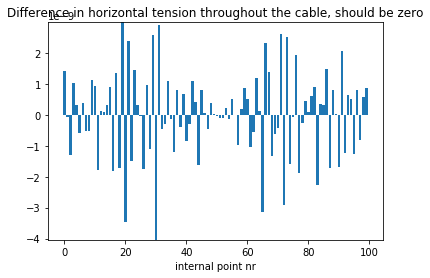

In [18]:
# Check the horizontal tension in the cable
# Two cables are connected to each of the internal points. Both cables should have the same horizontal
# tension and pull in opposite direction. Hence the total horizontal force on each of the internal pois
# should be zero

fx = []
for i in range(segments):
    poi = s[f'poi{i}']
    fx.append(poi.applied_force_and_moment_global[0])

plt.bar(range(segments),fx)
plt.title('Difference in horizontal tension throughout the cable, should be zero')
plt.xlabel('internal point nr')

-0.16880322576724893
-0.16880322999242026


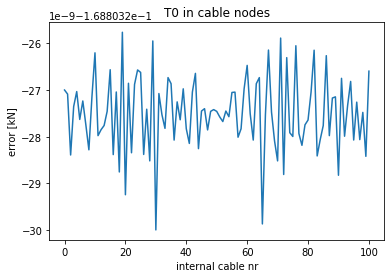

In [19]:
# we can also get the horizontal component from the cable tension
# and the cable direction
T0_cables_error = []

for cable in s.nodes_of_type(Cable):
    tension = cable.tension
    endA = cable.connections[0]  # the the endpoints
    endB = cable.connections[1]

    dx = endB.gx - endA.gx        # the horizontal distance
    dz = endB.gz - endA.gz
    ds = sqrt(dx*dx + dz*dz)

    Th = tension * dx / ds

    T0_cables_error.append(Th - T0)

plt.plot(T0_cables_error)
plt.title('T0 in cable nodes')
plt.ylabel('error [kN]')
plt.xlabel('internal cable nr')

import numpy as np

print(np.max(T0_cables_error))
print(np.min(T0_cables_error))

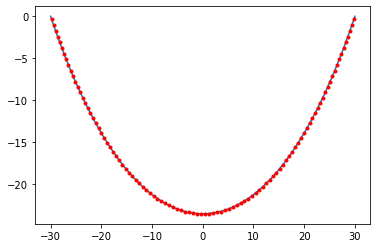

In [20]:
def y_analytical(x):
    return a * cosh(x/a)

xs = np.linspace(-x, x, num=100)
ys = y_analytical(xs)
y0 = y_analytical(x)

plt.plot(xs, ys-y0, label='analytical')

for b in s.nodes_of_type(RigidBody):
    plt.plot(b.gx, b.gz,'r.')